# Maze on Fire

Intro to AI Project 1

Reagan McFarland (rpm141), Alay Shah (acs286), Toshanraju Vysyaraju (tv135)

Imports:
- The only non standard import here is trange from tqdm, but all uses of `trange` can be replaced with `range` with no change in results - just no neat progress bar :) 

In [3]:
# imports
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from copy import deepcopy
import random
import numpy as np
from tqdm.notebook import trange
from tqdm.notebook import tqdm
from queue import PriorityQueue, Queue
from pprint import pprint
import math

## Problem 1

### Generating a maze

When thinking about how we were going to generate the maze, we first wanted to figure out a good way to render the maze in `jupyter notebooks`. This led us to color maps in `matplotlib` using a custom color map, allowing us to mark nodes certain colors based on the value. This resulted in us going with a 2D list of boolean values, where:
- `False` = open cell
- `True` = occupied cell 

We also wanted to make it as easy as possible to reuse, so we have optional params `p` and `dim`, representing the obstacle density and dimension respecitively. We also have the optional params `start` and `goal` as a tuple, that we can use to force those spaces to be empty. These optional params get re-used in almost every function. This is all done in the function `gen_maze`.

In [4]:
# globals here
DEFAULT_P = 0.1
DEFAULT_DIM = 20
DEFAULT_START = 0,0
DEFAULT_GOAL = DEFAULT_DIM-1, DEFAULT_DIM-1

def gen_maze(p=DEFAULT_P, dim=DEFAULT_DIM, start: tuple = DEFAULT_START, goal: tuple = DEFAULT_GOAL):
    maze = [[random.random() <= p for _ in range(dim)] for _ in range(dim)]
    sX, sY = start
    gX, gY = goal
    maze[sX][sY] = 0
    maze[gX][gY] = 0
    return maze

### Rendering a maze
We also wanted a method to show a color map plot of our maze, and settled on the following function after reading the `matplotlib` docs.

Notice that we can pass in the index as a tuple for both the start and end if needed. This is because we render these as gray instead of white / black making it easier to see the start and goal of the maze. These are optional params though of course. This is done in the function `render_maze`.

In [5]:
'''
USE THIS FOR COLORING NODES:
1 for obstacle
0 for empty
.5 for visited
2 for fire
-0.5 for path
'''
OBSTACLE = 1
EMPTY = 0
VISITED = 0.5
FIRE = 2
PATH = -0.5

def render_maze(maze: list, start: tuple = DEFAULT_START, goal: tuple = DEFAULT_GOAL, fire: bool = False, traceNodes: bool= False, tracePath:bool = False, showValues: bool = False):
    # change start and goal to be .5 so the color map makes them gray - easier to see on the render
    # this works because even though our list is full of booleans, matplotlib treats them as 0's and 1's
    sX, sY = start
    gX, gY = goal
    dim = len(maze)
    maze[sX][sY], maze[gX][gY] = VISITED, VISITED
    fig = plt.figure(figsize=(DEFAULT_DIM,DEFAULT_DIM), dpi=100)
    ax = fig.add_subplot(222)
    ax.set_xticks(np.arange(-0.5, dim, 1))
    ax.set_yticks(np.arange(-0.5, dim, 1))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
    ax.grid(which='major', axis='both', linestyle='-', color='0', linewidth=0.1)
    ax.set_title('maze')
    a = np.array(maze)
    c = [[0,255,255,255],[1,0,0,0],[.5,128,128,128]]#create custom color map
    if fire: 
         c.append([FIRE,225,0,0]) # if there is a fire add the fire color
    if traceNodes:
        c.append([-1,0,255,0]) #if we need to traceNodes, add the trace color
    ca = np.array(c)
    colors = ca[ca[:,0].argsort()][:,1:]/255.
    cmap = ListedColormap(colors)

    # optional value settings
    if showValues:
      for (i,j), z in np.ndenumerate(maze):
        ax.text(j,i, str(z), ha='center', va='center')

    plt.imshow(a, cmap=cmap)

    # change back
    maze[sX][sY], maze[gX][gY] = EMPTY, EMPTY

Putting these together, we can generate an example maze with `p=0.3` and `dim=20`

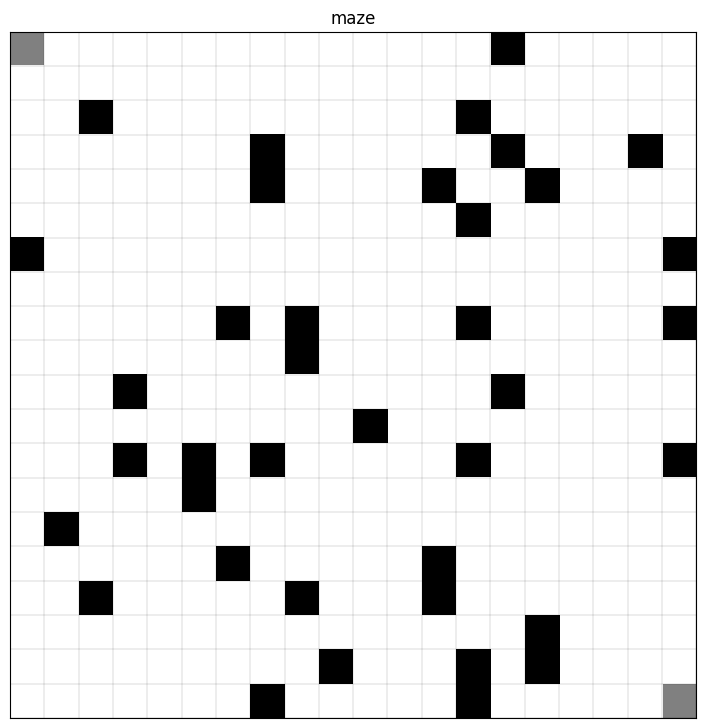

In [6]:
example_maze = gen_maze()
# example_maze2 = gen_maze(0.5, 50) # we could also do this if we wanted to specify the object density and dimensions explicitly
render_maze(example_maze)

## Problem 2

### Our DFS Algorithm
DFS is a very rudimentary search algorithm, with the only real decision to be made when implementing is whether or not you want to a recursive or iterative approach. We decided to go with a iterative approach just because its easier to transform into BFS later. We also have optional params here for our start and end cell indexes because our start and end goals are pre-determined for most of our test cases, but can be changed if needed with little alteration. We also have a traceNodes optional parameter which will highlight then nodes visited whenever we pass the maze to `render_maze()`. All this is implemented in the function `DFSUninformed`.
 

In [7]:
def DFSUninformed(maze, start: tuple = DEFAULT_START, goal: tuple = DEFAULT_GOAL, traceNodes: bool = False):
    #fringe
    stack = [] 
    maze_dim = len(maze)
    #keeps track of which cells are added to the fringe
    visited = [[0 for _ in range(maze_dim)] for _ in range(maze_dim)]
    sX, sY = start
    gX, gY = goal
    stack.append([sX, sY])
    #while the stack still has cells in it
    while stack:
        loc = stack.pop()
        visited[loc[0]][loc[1]] = OBSTACLE
        
        if traceNodes:
            maze[loc[0]][loc[1]] = VISITED
        
        #if we have reached the goal
        if loc[0] == gX and loc[1] == gY: 
            return True
        
        #delta array to visit all immediate neighbors
        horz = [1,-1,0,0]
        vert = [0,0,1,-1]
        #go through all neighbors
        for i in range(4):
            nX = loc[0]+vert[i]
            nY = loc[1]+horz[i]
            if nX < maze_dim and nX >= 0 and nY < maze_dim and nY >= 0: #if the coordinates are in the maze
                if maze[nX][nY] != 1 and maze[nX][nY]!= 2 and visited[nX][nY] != 1: #if the cell is not an obstacle/ on fire and if it hasnt been visited
                        stack.append([nX,nY])  #add to fringe 
    return False #if we have exhausted the fringe, then we cannot reach the goal

### Why is DFS a better choice than BFS here?
DFS is a better choice than BFS here because we do not need to find an optimal path. This allows us to save on the space complexity as our fringe is exponentially smaller as we proved in class. In addition, we know the goal node to be the furthest point from the start, i.e. the deepest part of the graph. DFS benefits greatly because it goes further down one path rather than exploring all neighbors, like BFS. Therefore as DFS searches for the 'deepest' node, it is a much better option in this scenario. 

### Obstacle Density `p` vs. Probabilty that `S` can be reached from `G`

Our machine could handle dimension of 100 with 100 samples per object density `p` we test. We are testing all `p` between `0` and `1`, with a step of `0.1` for each iteration.

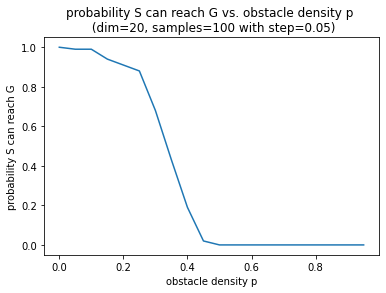

In [8]:
# Settings
SAMPLE_COUNT = 100
STEP = 0.05
DIMENSION = 100

# Code to generate graph 
densities = np.arange(0, 1, STEP).tolist()
successes = dict()
maze = None
density_count = len(densities)
with tqdm(total=density_count * SAMPLE_COUNT) as pbar:
    for i in range(len(densities)): 
        p = densities[i]
        if p not in successes:
            successes[p] = 0
        for j in range(SAMPLE_COUNT):
            maze = gen_maze(p,DIMENSION)
            successes[p] += DFSUninformed(maze)
            pbar.update(1)

x_axis = densities
y_axis = [successes[x] / SAMPLE_COUNT for x in densities]

plt.xlabel("obstacle density p")
plt.ylabel("probability S can reach G")
plt.title("probability S can reach G vs. obstacle density p \n (dim=" + str(DEFAULT_DIM) + ", samples=" + str(SAMPLE_COUNT) + " with step=" + str(STEP) + ")")
plt.plot(x_axis, y_axis)


## Problem 3

### Our BFS Algorithm

BFS implements a queue instead of a stack in order to visit all neighbors before visiting children. This is done in our function `BFSUninformed` which returns if the goal is reached, the number of visited cells, the length of the path to the goal, and the actual path it took.

Before we begin, we first wanted to define a function `trace_path` that would trace the optimal path so we could visually see it on our graph. It will also return the length of the optimal path and the actual path it self (in a stack).

In [9]:
#returns the path length, the maze and the actual path found by BFS or A*
def trace_path(maze: list, previous:list, loc:list, start:tuple= DEFAULT_START, traceNodes: bool = False): 
    pLen = 0
    sX,sY = start
    stack = []
    color = PATH
    while True:
        stack.append(loc)
        lX,lY= loc
        if lX == sX and lY == sY:
            if traceNodes :
              maze[sX][sY] = color
            return pLen, maze, stack
        pLen=pLen+1
        if traceNodes:
          maze[lX][lY] = color
        loc = previous[lX][lY]

In [10]:
#returns if the goal was reached(T/F), number of visited cells, the length of the path to the goal, and the actual path
def BFSUninformed(maze:list, start: tuple = DEFAULT_START, goal: tuple = DEFAULT_GOAL, traceNodes: bool = False):
    dim = len(maze)
    queue = [] #set fringe
    #keeps track of which nodes that have been in the fringe
    visited = [[0 for _ in range(dim)] for _ in range(dim)]
    #keeps track of parent nodes 
    previous = [[0 for _ in range(dim)] for _ in range(dim)]
    
    gX, gY = goal
    sX, sY = start
    
    queue.append(start)
    
    loc = start
    #start has been added to fringe
    visited[sX][sY] = 1
    #keeps track of the number of nodes visited
    numVisited = 0
    #have we reached the goal 
    goalHit = False
    
    while queue:
        
        numVisited= numVisited+1 #increment number of visited nodes
        
        loc = queue.pop(0) #pull from fringe
        
        if(loc[0]==gX and loc[1]==gY): #we have reached G
            goalHit = True
            break
       
        
        if traceNodes:
            maze[loc[0]][loc[1]] = VISITED
        
        #delta array
        horz = [1,0,0,-1]
        vert = [0,-1,1,0]
        
        #visit children
        for i in range(4):
            nX = loc[0]+horz[i]
            nY = loc[1]+vert[i]
            if nX < len(maze) and nX >= 0 and nY < len(maze) and nY >= 0: #in the maze
                if maze[nX][nY] != 1 and maze[nX][nY]!=2 and visited[nX][nY] != 1: #isn't an obstacle and hasnt been added to the fringe and isnt on fire
                    visited[nX][nY] = 1 #set added to fringe to true
                    previous[nX][nY] = loc #set the parent of node in prev array
                    queue.append([nX,nY]) #add to fringe
    pLen, maze, path = trace_path(maze, previous, loc, traceNodes=traceNodes, start=start) #traces path and returns the length of the optimal path found
    return goalHit, numVisited, pLen, path

### Our A* Algorithm

Before we implement our `A*` algorithm, we need to define a function that can give us the euclidean distance between a cell and the goal cell. This is done in the function `euclid`.

In [11]:
def euclid(position: tuple, goal: tuple = DEFAULT_GOAL): #calculated euclidean distance
    x, y = position
    gX, gY = goal
    return math.sqrt(((x-gX)*(x-gX)) + ((y-gY)*(y-gY)))

With the heuristic defined, we can now write the A* algorithm in the function `AStar` using almost the same functionality as BFS. However, we are using a `PriorityQueue` instead of a normal queue. The priority queue orders cells with a lower cost based on the heuristic and actual cost from low to high.

In [12]:
#returns if the goal was reached(T/F), number of visited cells, the length of the path to the goal, and the actual path
def AStar(maze: list,start: tuple = DEFAULT_START, goal: tuple = DEFAULT_GOAL, traceNodes: bool = False ):
    
    dim = len(maze)
    #keeps track of the nodes that have already been visited
    visited = [[0 for _ in range(dim)] for _ in range(dim)]
    #keeps track of cost to reach the node i,j
    costs = [[0 for _ in range(dim)] for _ in range(dim)]
    #keeps track of the parent node of each node
    previous = [[0 for _ in range(dim)] for _ in range(dim)]
    
    sX, sY = start
    gX, gY = goal
    loc = start
    
    #init heap
    heap = PriorityQueue()
    #put start in the heap
    heap.put((euclid(start, goal), start))
    
    #start node cost = 0
    costs[sX][sY] = 0
    #we added start to fringe
    visited[sX][sY] = 1
    
    #keeps track of number of visited nodes
    numVisited = 0
    
    #if goal node is reached
    goalHit = False
    
    while not heap.empty():
        
        numVisited = numVisited + 1 #increment # visited nodes 
        
        _,loc = heap.get() #get loc of the least est cost node
        
        if(loc[0]==gX and loc[1]==gY): #if Goal is reached
            goalHit=True
            break
        
        childCost = costs[loc[0]][loc[1]] + 1  #children = actual cost of parent + 1
        
        if traceNodes: 
            maze[loc[0]][loc[1]] = 0.5 
        
        #delta arrays
        horz = [1,0,0,-1]
        vert = [0,-1,1,0]

        #visit children
        for i in range(4):
            nX = loc[0]+horz[i]
            nY = loc[1]+vert[i]
            if nX < len(maze) and nX >= 0 and nY < len(maze) and nY >= 0: #in maze
                if maze[nX][nY] != 1 and maze[nX][nY] != 2 and visited[nX][nY] != 1: #not obstacle and not added to fringe yet
                    visited[nX][nY] = 1 #added to fringe True
                    previous[nX][nY] = loc #set parent 
                    costs[nX][nY] = childCost #set actual cost
                    totalEstC = euclid((nX,nY), goal)+childCost #heurestic+ actual cost
                    heap.put((totalEstC, [nX,nY])) #add to fringe

    pLen, maze, path = trace_path(maze, previous, loc, traceNodes=traceNodes , start=start) #traces optimal path and gives length of optimal path
    return goalHit, numVisited, pLen, path

We can view a random example of how the number of nodes A* visits vs. BFS differs. In the below mazes, the grey represents cells that were visited and the green represents the optimal path returned. The white cells are the cells which are not visited. It is important to note that there are multiple optimal paths and so the BFS path may not be identical to the A\* path but they both have identical length.

BFS Nodes Visited = (True, 31817, 398)
A* Nodes Visited = (True, 30244, 398)


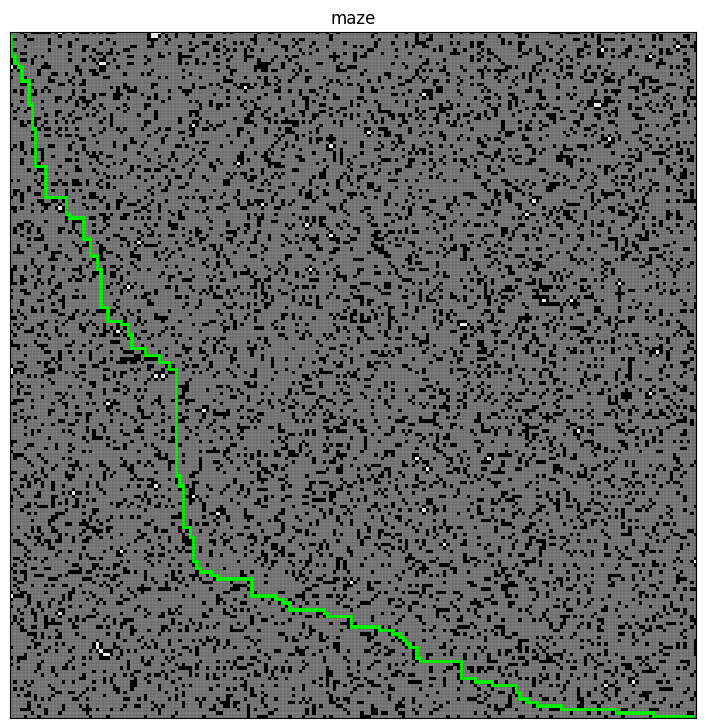

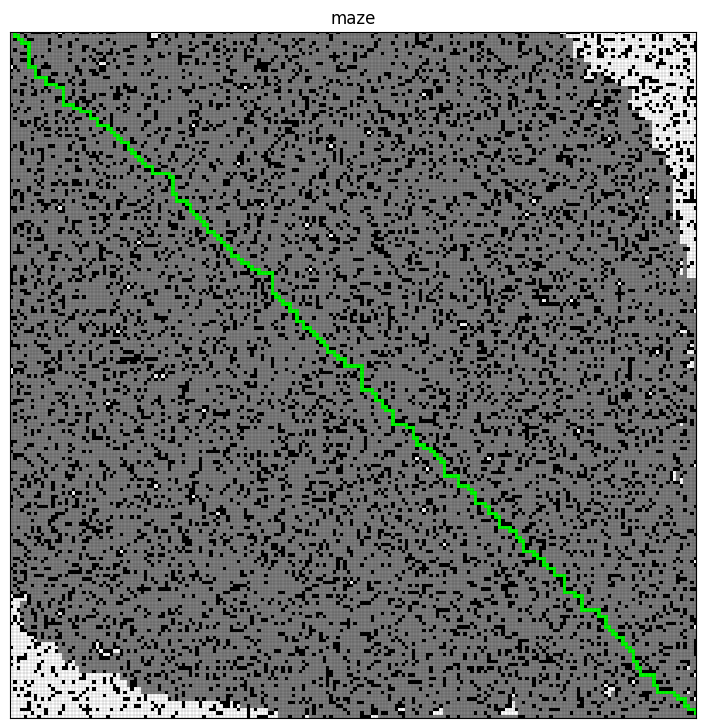

In [13]:
maze_bfs = gen_maze(0.2, 200)
maze_astar = deepcopy(maze_bfs)
goal=(len(maze_bfs)-1, len(maze_bfs)-1)
bfs = BFSUninformed(maze_bfs, goal=goal, traceNodes=True)
astar = AStar(maze_astar,goal=goal, traceNodes=True)
print("BFS Nodes Visited = " + str(bfs[0:3]))
render_maze(maze=maze_bfs, goal=goal, traceNodes=True)
print("A* Nodes Visited = " + str(astar[0:3]))
render_maze(maze=maze_astar, goal=goal, traceNodes=True)

### Number of nodes explored by BFS - number of nodes explored by A* vs. obstacle density `p`

In order to graph this, we are going to use the same assumption for the last graph about sample sizes, steps, etc. On top of this, we are going to create a function that for every single sample, will do the following:
1. Generate a new maze
2. Run BFS and record the number of nodes explored
3. Run A* and record the number of nodes explored

Then, at the end we will average these out across the steps and graph it using matplotlib. First, let's create that function `diff_AStar_BFS` that will do all the 3 steps above.

In [14]:
def diff_AStar_BFS(p=DEFAULT_P, dim=DEFAULT_DIM): #returns the difference between the number of visited nodes for a given maze for A* and BFS
    goal = (dim-1, dim-1)
    new_maze = gen_maze(p, dim)
    bfs_result, bfs_visited_nodes, bfs_path_length, bfs_path = BFSUninformed(new_maze, goal=goal)
    astar_result, astar_visited_nodes, astar_path_length, astar_path = AStar(new_maze, goal=goal) 
    return bfs_visited_nodes - astar_visited_nodes

Now, let's write some code to generate to generate the data for the graph and then also render it, just like before.

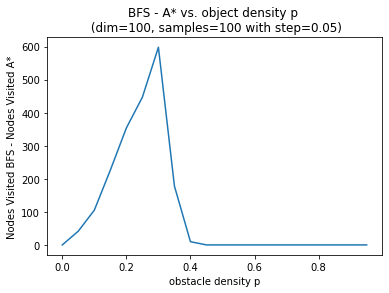

In [22]:
# Settings
SAMPLE_COUNT = 100
STEP = 0.05
DIMENSION = 100

# Code to generate graph 
densities = np.arange(0, 1, STEP).tolist()
successes = dict()
density_count = len(densities)
with tqdm(total=density_count * SAMPLE_COUNT) as pbar:
    for i in range(len(densities)): 
        p = densities[i]
        if p not in successes:
            successes[p] = 0
        for j in range(SAMPLE_COUNT):
            successes[p] += diff_AStar_BFS(p, DIMENSION)
            pbar.update(1)

x_axis = densities
y_axis = [successes[x] / SAMPLE_COUNT for x in densities]

plt.xlabel("obstacle density p")
plt.ylabel("Nodes Visited BFS - Nodes Visited A*")
plt.title("BFS - A* vs. object density p \n (dim=" + str(DIMENSION) + ", samples=" + str(SAMPLE_COUNT) + " with step=" + str(STEP) + ")")
plt.plot(x_axis, y_axis)


### If there is no path from S to G, what should this difference be?
If there is no path, then the difference will be 0. This is because both algorithms will have to check all the same nodes before it can 100% be sure that there is no path. Both algorithms are using a queue, its just that A* will probably get there faster because its using a priority queue with a heuristic. The algorithm cannot know that the path is blocked and the heurestic is rendered useless, so in both cases, it will explore each possibility in hopes of finding the goal node. Therefore, the difference in the number of nodes traversed for each algorithm will be the same when there is no path.

## Problem 4

### What's the largest dimension you can solve using DFS at `p=0.3` in less than a minute?

In [ ]:
DFS_LARGEST_DIM = 4350
dfs_goal = (DFS_LARGEST_DIM-1, DFS_LARGEST_DIM-1)
dfs_maze = gen_maze(0.3, DFS_LARGEST_DIM, start=(0,0), goal=dfs_goal)

In [ ]:
%%time
DFSUninformed(dfs_maze, goal=(DFS_LARGEST_DIM-1, DFS_LARGEST_DIM-1), traceNodes=True)

**Through trial and error, we found that the largest maze with density `p=0.3` that we can will solve is around 4350x4350**

### What's the largest dimension you can solve using BFS at `p=0.3` in less than a minute?

In [ ]:
BFS_LARGEST_DIM = 4500
bfs_goal = (BFS_LARGEST_DIM-1,BFS_LARGEST_DIM-1)
bfs_maze = gen_maze(0.3, BFS_LARGEST_DIM, start=(0,0), goal=bfs_goal)

In [ ]:
%%time
bfs_res = BFSUninformed(bfs_maze, goal=(BFS_LARGEST_DIM-1, BFS_LARGEST_DIM-1), traceNodes=True)
print(bfs_res)

**Through trial and error, we found that the largest maze with density `p=0.3` that we can will solve is around 4500x4500**

### What's the largest dimension you can solve using A* at `p=0.3` in less than a minute?

In [ ]:
ASTAR_LARGEST_DIM = 14000
a_goal = (ASTAR_LARGEST_DIM-1, ASTAR_LARGEST_DIM-1)
a_maze = gen_maze(0.3, ASTAR_LARGEST_DIM, goal=a_goal)

In [ ]:
%%time
res = AStar(a_maze, goal=a_goal, traceNodes=True)
print(res)

**Through trial and error, we found that the largest maze with density `p=0.3` that we can solve is around 15000x15000**

###Consider, as you solve these three problems, simple diagnostic criteria to make sure you areon track. The path returned by DFS should never be shorter than the path returned by BFS.The path returned by A\* should not be shorter than the path returned by BFS. How big can andshould your fringe be at any point during these algorithms?
In the maze, each node has at most 4 neighbors (up, down, left, right). In class we derived the space complexity of the fringes. Here, we will treat A\* and BFS as the same, since we are dealing with worst case (i.e. $h(n)$ is the same for all nodes). Let $n$ be the size of the maze. Then we arrive at a space complexity of $O(4n)$ for DFS. However, in the case of BFS and A\*, the space complexity of our fringe will be $O(4^n)$.  At runtime, the A\* algorithm might have a fringe smaller than $O(4^n)$ as it only explores the nodes that bring it closer to the goal node, but ultimately it is also bounded by a space complexity of $O(4^n)$.

# Part 2 Maze on Fire
Looking at non-static mazes, there is a fire that is acitvely burning down and we need to get out before running into the fire. Solving for the current state may not work for future states of the maze. 


##Generating a maze
We decided to re-use our `gen_maze(dim, p)` function to create the maze and then choose a random cell to be on fire. To ensure that the goal and start nodes are not the starting points of the fire, we used a function `randomFirestart(dim)` to properly pick the starting point of the fire. We then use the method `gen_fireMaze` to generate a maze with a random fire start cell.

In [16]:
def randomFireStart(dim):
    #select random x, y coordinates on the maze
    x = random.randint(0,dim-1)  
    y = random.randint(0,dim-1)
    if x == 0 and y == 0 or x == dim-1 or y==dim-1: #if we choose the start or end of the maze randomly, use another random point
        return randomFireStart(dim)
    return x,y

Putting it all together.

In [17]:
def gen_fireMaze(dim = DEFAULT_DIM, p = DEFAULT_P): #dimensions, prob obstacle, prob fire spread
    #create maze
    maze = gen_maze(p, dim, goal=(dim-1,dim-1))
    #random tile where fire starts
    fire = randomFireStart(dim)
    maze[fire[0]][fire[1]] = 2 #fire flag
    return maze, fire

###Expanding the fire
We create a matrix that houses the current state of the fire, and based on that will determine which cells will be on fire in the method `expandFireOneStep`, using the stated parameters:


*   If a free cell has no burning neighbors, it will still be free in the next time step.
* If a cell is on fire, it will still be on fire in the next time step.
* A blocked cell cannot catch on fire.
* If a free cell has $k$ burning neighbors, it will be on fire in the next time step with probability $1 − (1 − q)^k$





In [18]:
def expandFireOneStep(maze:list,q, start: tuple = DEFAULT_START, goal:tuple = DEFAULT_GOAL):
  dim = len(maze)
  fire = 2 #fire flag
  #generates the current state of the fire
  firePos = [[0 for _ in range(dim)] for _ in range(dim)]
  for i in range(dim):
    for j in range(dim):
      if(maze[i][j]==fire):
        firePos[i][j]=fire
    
  #expanding the fire one step
  for i in range(dim):
    for j in range(dim):
      # if the cell is already on fire or is an obstacle, skip
      if(maze[i][j]==fire or maze[i][j]==1): 
        continue
            
      #count num of neighbors on fire
      k = 0 
      horz = [1,-1,0,0]
      vert = [0,0,1,-1]
      for m in range(4):
        nX = i + vert[m]
        nY = j + horz[m]
        if(nX<len(maze) and nX>=0 and nY<len(maze) and nY>=0): #check if coordinates are in the maze
          if(firePos[nX][nY]==fire): #if neighbor is on fire, increment count
            k = k+1
      prob = 1-((1-q)**k) #prob of fire as defined
      if(random.random()<=prob): 
        maze[i][j] = fire #set node on fire if rand is less than prob
  return maze

We can illustrate this function by rendering maze with `dim=20, p=0.3 , `and` q=0.3`, and having the fire expand 10 steps. 

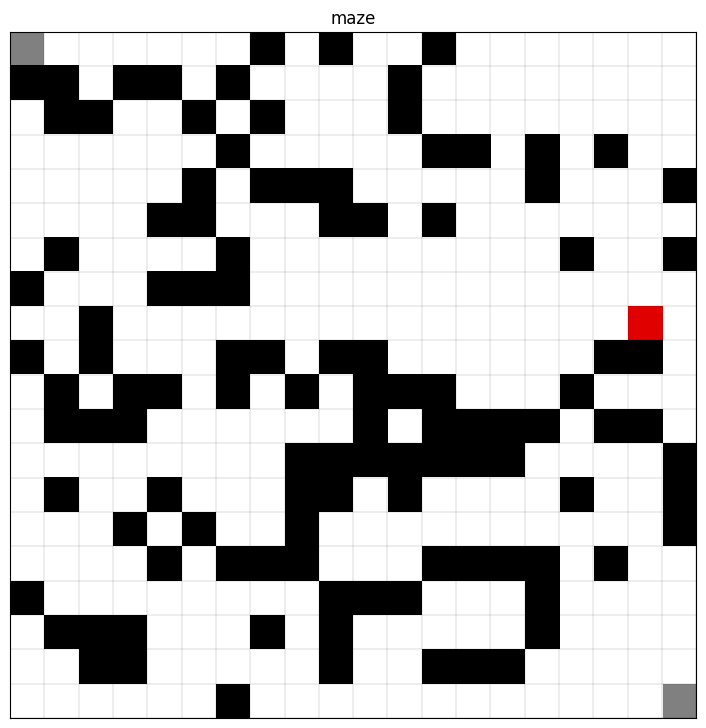

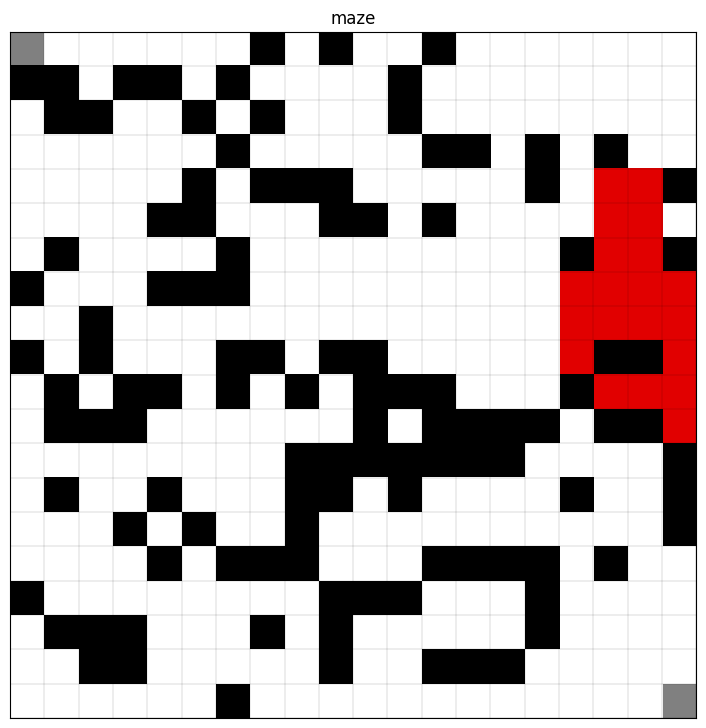

In [25]:
maze,_ = gen_fireMaze(dim=20, p=0.3)
render_maze(maze,goal=(19,19),fire=True)
for i in range(10):
    maze = expandFireOneStep(maze, 0.3)
render_maze(maze,goal=(19,19),fire=True) 

##Strategy 1, No Strategy
We will use A\* to calculate the shortest path to the goal and follow as if there was no fire in the method `strat_one`. This strategy blindly follows the path that A\* returns and does not account for the current or future states of the fire.

In [ ]:
def strat_one(maze:list, q: float, goal:tuple = DEFAULT_GOAL, start:tuple=DEFAULT_GOAL, traceNodes: bool = False):
  _,_,_,path = AStar(maze, goal=goal)
  gX, gY = goal
  hitGoal = False

  while path:

    lX,lY = path.pop()
    
    if(maze[lX][lY]==2): #if the next step is in the fire
      #print("agent died in fire")
      return hitGoal, maze
    
    if lX == gX and lY == gY:
      hitGoal = True
    if traceNodes:
      maze[lX][lY]= PATH

    maze = expandFireOneStep(maze, q)
    if (maze[lX][lY]==2): # if the fire expands to agent on this step
      #print("agent died in fire")
      return hitGoal, maze
  
  return hitGoal, maze


With strategy 1 now well defined, let us create a method `test_strat1` to test it easily for a given dimension and fire spreading rate. For each test, we will generate the fire start position randomly 10 times and return the number of successes encountered.

In [ ]:
#create 1 maze 10 times and run the strategy at different fire points
#for each q step, run it 10 times
#returns int from 0-10 
def test_strat1(dim, q):
  count = 0
  successes = 0
  goal = (dim-1, dim-1)
  maze = gen_maze(dim=dim, p=0.3, goal=goal)
  #make sure the maze is solvable
  while True: 
    if DFSUninformed(maze, goal=goal):
      break
    maze = gen_maze(dim=dim, p=0.3, goal=goal)
  
  #run each maze 10 times, with different fires
  while count < 10:

    mazeF = deepcopy(maze)
    #start fire on the maze
    fX, fY = randomFireStart(dim) 
    mazeF[fX][fY] = 2

    #make sure that the maze is still solvable and the fire can reach the agent
    if not (DFSUninformed(mazeF, goal=goal) and DFSUninformed(mazeF,start=(fX,fY), goal=(0,0))):
      continue
    #run strategy 1
    hitGoal, _ = strat_one(maze = mazeF, q = q, goal = goal)
    
    if hitGoal: #if we hit the goal, increment successes
      successes += 1
  
    count+=1
  
  return successes


Now with our testing method `test_strat1` defined above, we can average out probability of success over a defined interval and graph the results. In the graph shown below, we ran Strategy 1 with `dimension 20`, `sample count 20`, and increased `q` by `0.1`.

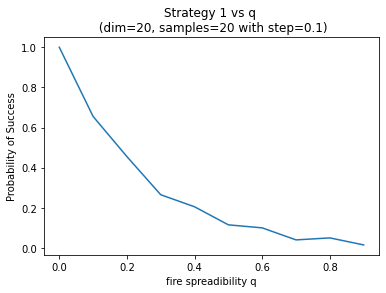

In [ ]:
# Settings
SAMPLE_COUNT = 20
STEP = 0.1
DIMENSION = 20

successes = dict()

# Code to generate graph 
densities = np.arange(0, 1, STEP).tolist()
density_count = len(densities)
with tqdm(total=density_count * SAMPLE_COUNT) as pbar:
    for i in range(len(densities)): 
        q = densities[i]
        if q not in successes:
            successes[q] = 0
        for j in range(SAMPLE_COUNT):
            successes[q] += test_strat1(dim=DIMENSION, q=q)
            pbar.update(1)

x_axis = densities
strat_1_y_axis = [successes[x] / (SAMPLE_COUNT * 10) for x in densities]

plt.xlabel("fire spreadibility q")
plt.ylabel("Probability of Success")
plt.title("Strategy 1 vs q \n (dim=" + str(DIMENSION) + ", samples=" + str(SAMPLE_COUNT) + " with step=" + str(STEP) + ")")
plt.plot(x_axis, strat_1_y_axis)

## Strategy 2, Recompute Path at Every Step

Strategy 2 is very similar to Strategy 1 but we recalculate our A* path at every step making sure to update our path to take into account the changes in our fire. This is done in the method `strat_two`.

In [19]:
def strat_two(maze:list, q: float, goal:tuple = DEFAULT_GOAL, start:tuple=DEFAULT_START, traceNodes: bool = False):
  _,_,_,path = AStar(maze, goal=goal, start=start)
  lX, lY = start
  gX, gY = goal
  hG = False
  while path:
    #recompute the shortest path, while taking into account the current state of fire
    _,_,_,path = AStar(maze, start=(lX,lY), goal=goal)

    path.pop() #current position

    if not path: #if there are no moves in the path
      break
    
    lX,lY = path.pop() #next position
    
    if lX == gX and lY == gY: #if we hit the goal
      hG = True
      break

    if traceNodes:
      maze[lX][lY]= PATH

    maze = expandFireOneStep(maze, q)
  
    if maze[lX][lY] == 2: #if the fire expands to agent on this step
      break
  
  return hG, maze

With strategy 2 now well defined, let us create a method `test_strat2` to test it easily for a given dimension and fire spreading rate. For each test, we will generate the fire start position randomly 10 times and return the number of successes encountered.

In [20]:
#create 1 maze 10 times and run the strategy at different fire points
#for each q step, run it 10 times

def test_strat2(dim, q):

  count = 0
  suc = 0
  goal = (dim-1, dim-1)
  maze = gen_maze(dim=dim, p=0.3, goal=goal)

  #make sure maze is solvable
  while True: 
    if DFSUninformed(maze, goal=goal):
      break
    maze = gen_maze(dim=dim, p=0.3, goal=goal)
  
  #run maze 10 times with 10 different fires
  while count<10:
    
    mazeF = deepcopy(maze)
    fX, fY = randomFireStart(dim)
    mazeF[fX][fY] = 2
   
    #make sure that the maze is still solvable and the fire can reach the agent
    if not (DFSUninformed(mazeF, goal=goal) and DFSUninformed(mazeF,start=(fX,fY), goal=(0,0))):
      continue
    
    #run strategy 2
    hitGoal, _ = strat_two(maze=mazeF, q=q, goal=goal)
    
    if hitGoal: #if we hit the goal, increment successes
      suc+=1

    count+=1
  return suc

Now with our testing method `test_strat2` defined, we can average out probability of success over a defined interval and graph the results. In the graph shown below, we ran Strategy 2 with `dimension 20`, `sample count 20`, and increased `q` by `0.1`.

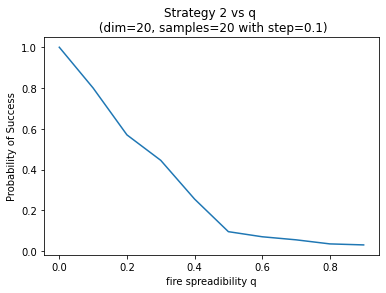

In [21]:
# Settings
SAMPLE_COUNT = 20
STEP = 0.1
DIMENSION = 20

successes = dict()

# Code to generate graph 
densities = np.arange(0, 1, STEP).tolist()
density_count = len(densities)
with tqdm(total=density_count * SAMPLE_COUNT) as pbar:
    for i in range(len(densities)): 
        q = densities[i]
        if q not in successes:
            successes[q] = 0
        for j in range(SAMPLE_COUNT):
            successes[q] += test_strat2(dim=DIMENSION, q=q)
            pbar.update(1)

x_axis = densities
strat_2_y_axis = [successes[x] / (SAMPLE_COUNT * 10) for x in densities]

plt.xlabel("fire spreadibility q")
plt.ylabel("Probability of Success")
plt.title("Strategy 2 vs q \n (dim=" + str(DIMENSION) + ", samples=" + str(SAMPLE_COUNT) + " with step=" + str(STEP) + ")")
plt.plot(x_axis, strat_2_y_axis)

## Problem 5 - Strategy 3, Future Risk Adjusted Path (FRAP)

### Describe your improved Strategy 3. How does it account for the unknown future?

Strategy 3 is our way to solve this maze on fire problem. The problem with Strategy 2 is that it fails to take into account the future state of the maze, resulting in sub-optimal results. Unlike Strategy 1 and Strategy 2, our Strategy 3 takes into account not only the current state of the fire but also potential future states of the fire. To do this, we generate a fire map that takes in the current state of the maze, including what is on fire currently. From this, assuming a worst case `q = 1.0` fire spread probability, we calculate at what step each cell will catch on fire and is therefore a representation of the future of the fire. This is then used to create a weighting for each cell. This weighting is based on the cell's proximity to the goal as well as at which step it will be on fire in the worst case (based on the fire map) and at which step the cell will be visited by our agent. These weights are used as the heuristics for A\*. More specifically, the cost of the cell in the fringe is equal to the manhattan distance to the goal + the cost to reach the goal - the cell's value in the fire map.

The first step in this process is to create a list, mapping a tuple of x,y coordinates to the worst case fire expansion at a given cell. What we mean by this is that if the fire starts at some arbitrary cell `C`, we can assume the worst conditions for the fire (`q = 1.0`), and calculate for each cell in the grid how many steps it would take for it to reach it. To implement this, we will define a function `generate_fire_step_maze`, which will generate and return this list for a given maze.

In [ ]:
def generate_fire_step_maze(maze: list) -> tuple:
  fire_step_map = dict()
  maze_dim = len(maze)
  fire_step_maze = [[-1 for _ in range(maze_dim)] for _ in range(maze_dim)]

  dirs = [(1,0), (-1,0), (0,1), (0,-1)]

  iteration = 0
  cells = Queue() 

  #find all cells on fire and add to queue
  for i in range(len(maze)):
    for j in range(len(maze)):
      if maze[i][j] == FIRE:
        cells.put((i,j))
  
  while not cells.empty():
    cells_this_step = cells.qsize()
    for i in range(cells_this_step):
      cX, cY = cells.get() # current x,y
      
      # Check if we've already been here
      if (cX, cY) in fire_step_map: continue

      # add current cell to hashmap
      fire_step_map[(cX,cY)] = iteration
      fire_step_maze[cX][cY] = iteration
      
      # check neighbors
      for dX,dY in dirs: 
        # new x,y
        nX, nY = cX + dX, cY + dY

        if (nX,nY) not in fire_step_map:
          # check bounds
          if 0 <= nX and nX < maze_dim and 0 <= nY and nY < maze_dim:
            #if not an obstacle, add to dict
            if maze[nX][nY] != 1:
              cells.put((nX,nY))

    iteration += 1

  return fire_step_map, fire_step_maze

We are also going to want a way to render this fire maze for visualization purposes, which is defined by the function `render_fire_maze`. The darker the cell is, the earlier it is on fire (in the worst case of `q = 1.0`) and the lighter the cell is, the later it is on fire.

In [ ]:
def render_fire_maze(maze: list, showValues: bool = False): 
    dim = len(maze)
    fig = plt.figure(figsize=(dim,dim))

    ax = fig.add_subplot(222)

    ax.set_xticks(np.arange(-0.5, dim, 1))
    ax.set_yticks(np.arange(-0.5, dim, 1))
    # ax.set_yticklabels([])
    # ax.set_xticklabels([])
    # maze[0][0] = math.floor(math.sqrt(dim)) + 20
    # maze[-1][-1] = math.floor(math.sqrt(dim)) + 20
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    ax.grid(which='major', axis='both', linestyle='-', color='0', linewidth=0.1)
    ax.set_title('maze')
    
  # optional value settings
    if showValues:
      for (i,j), z in np.ndenumerate(maze):
        ax.text(j,i, str(z), ha='center', va='center')

    plt.imshow(maze, interpolation='None')
    plt.set_cmap('Reds_r')
    fig = plt.figure(dpi=100)

    maze[0][0] = 0
    maze[-1][-1] = 0

We can take a look at a visualization of what we are talking about here, by rendering a view of a generated maze and its corresponding `fire_step_map`.

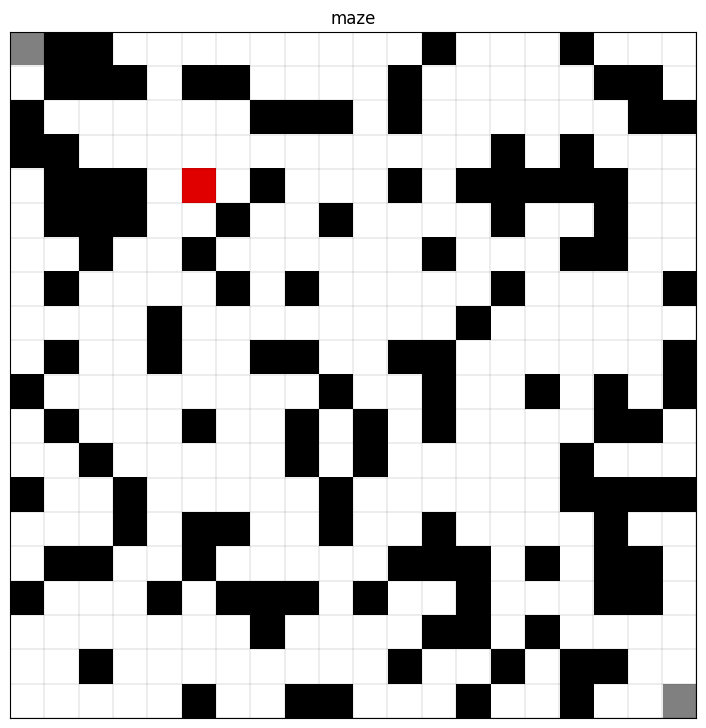

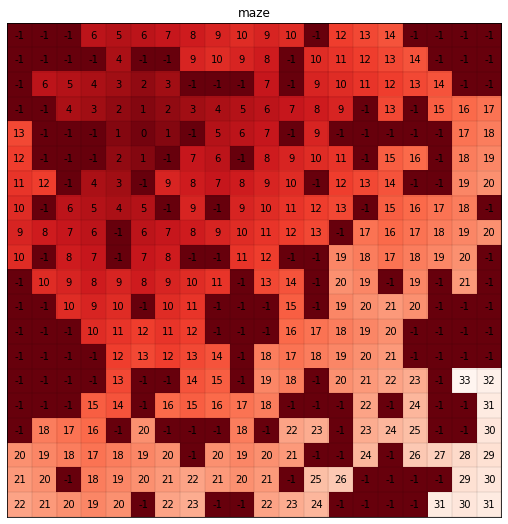

<Figure size 600x400 with 0 Axes>

In [ ]:
maze, fire = gen_fireMaze(20, 0.3)
fire_step_map, fire_step_maze = generate_fire_step_maze(maze)
render_maze(maze,goal=(19,19), fire=True)
render_fire_maze(fire_step_maze, showValues=True)

At this point we want to modify our A\* in order to account for the `fire_step_map`, i.e the future states of the maze. In addition, we will use the manhattan distance to weigh the nodes, this will allow us to explore optimal paths further away from the diagonal. We do all this in the functions `manHat` and `AStar_mod`.

In [ ]:
#return the manhattan distance from start to goal
def manHat(start: tuple, goal:tuple):
  sX,sY = start
  gX, gY= goal
  return abs(sX-gX)+abs(sY-gY)

In [ ]:
def AStar_mod(maze: list, fire_map: dict, start: tuple = DEFAULT_START, goal: tuple = DEFAULT_GOAL, traceNodes: bool = False ):
    
    dim = len(maze)
    #keeps track of the nodes that have already been visited
    visited = [[0 for _ in range(dim)] for _ in range(dim)]
    #keeps track of cost to reach the node i,j
    costs = [[0 for _ in range(dim)] for _ in range(dim)]
    #keeps track of the parent node of each node
    previous = [[0 for _ in range(dim)] for _ in range(dim)]
    
    sX, sY = start
    gX, gY = goal
    loc = start
    
    #init heap
    heap = PriorityQueue()
    #put start in the heap
    heap.put((manHat(start, goal), start))
    
    #start node cost = 0
    costs[sX][sY] = 0
    #we added start to fringe
    visited[sX][sY] = 1
    
    #keeps track of number of visited nodes
    numVisited = 0
    
    #if goal node is reached
    goalHit = False
    
    #will keep track of the closest node if there is no path to the goal
    closestNode = start
    closestCost = manHat(start, goal)

    while not heap.empty():
        
        numVisited = numVisited + 1 #increment # visited nodes 
        
        _,loc = heap.get() #get loc of the least est cost node
        lX,lY =loc
        if(loc[0]==gX and loc[1]==gY): #if Goal is reached
            goalHit=True
            break
        
        childCost = costs[loc[0]][loc[1]] + 1  #children = actual cost of parent + 1
        
        if traceNodes: 
            maze[loc[0]][loc[1]] = 0.5 
        
        #delta arrays
        horz = [1,0,0,-1]
        vert = [0,-1,1,0]

        #visit children
        for i in range(4):
            nX = loc[0]+horz[i]
            nY = loc[1]+vert[i]
            if (nX<len(maze) and nX>=0 and nY<len(maze) and nY>=0): #check coordinates with maze bounds
                if ((maze[nX][nY] != 1) and (maze[nX][nY]!=2) and (visited[nX][nY]!=1)): #not obstacle and not added to fringe yet
                        visited[nX][nY] = 1 #added to fringe True
                        previous[nX][nY] = loc #set parent 
                        costs[nX][nY] = childCost #set actual cost
                        manhatCost = manHat((nX,nY), goal) #calculate estimate distance to goal
                        totalEstC = manhatCost+childCost-fire_map[(nX,nY)] #heurestic+ actual cost
                        heap.put((totalEstC, [nX,nY])) #add to fringe
                        if (manhatCost<closestCost): #if node is closer than current closest, set current to closestNode
                          closestNode = (nX,nY)
                          closestCost = manhatCost
    loc = closestNode       
    pLen, maze, path = trace_path(maze, previous, loc, traceNodes=traceNodes , start=start) #traces optimal path and gives length of optimal path
    
    return goalHit, numVisited, pLen, path

Now we can implement our Strategy 3 in the function `strat_3`.

In [ ]:
#strategy 3, returns true if we hit the goal

def strat_three(maze:list, q: float, goal: tuple= DEFAULT_GOAL, start: tuple = DEFAULT_START, traceNodes:bool = False):
  
  hitGoal = False
  dead = False
  gX, gY = goal
  lX, lY = start
  iterations = 0


  while not hitGoal:
    
    iterations += 1

    fire_maze,_ = generate_fire_step_maze(maze) #calculate the worst case fire 
    _,_,_,path = AStar_mod(maze=maze, fire_map=fire_maze, start=(lX,lY), goal=goal)
    path.pop()
    
  
    if not path: #if there are no moves left
      _,_,_,path = AStar(maze=maze, start=(lX,lY), goal=goal) #we will try to escape the fire, i.e. strat 2 b/c the agent is doomed if it chooses to stay in place
      path.pop()
      if not path:
        break


    lX, lY = path.pop()

    if lX == gX and lY == gY: #if we reach goal node
      hitGoal=True
      break

    if maze[lX][lY] == 2: #if the next position is on fire
      break

    if traceNodes:
      maze[lX][lY] = -0.5

    maze = expandFireOneStep(maze, q)

    if maze[lX][lY] == 2: #if the fire expands to agent on this step
      break

  return hitGoal, maze      

With strategy 3 now well defined, let us create a method `test_strat3` to test it easily for a given dimension and fire spreading rate. For each test, we will generate the fire start position randomly 10 times and return the number of successes encountered. With our testing method `test_strat3` defined, we can average out probability of success over a defined interval and graph the results.

In [ ]:
def test_strat3(dim, q):

  count = 0
  suc = 0
  goal = (dim-1, dim-1)
  maze = gen_maze(dim=dim, p=0.3, goal=goal)

  #check if solveable
  while True: 
    if DFSUninformed(maze, goal=goal):
      break
    maze = gen_maze(dim=dim, p=0.3, goal=goal)

  #run maze 10 times with 10 different fires
  while count<10:
    #start fire
    mazeF = deepcopy(maze)
    fX, fY = randomFireStart(dim)
    mazeF[fX][fY] = 2

    #make sure that the maze is still solvable and the fire can reach the agent
    if not (DFSUninformed(mazeF, goal=goal) and DFSUninformed(mazeF,start=(fX,fY), goal=(0,0))): 
      continue
    #run strategy 3
    hitGoal, _ = strat_three(maze=mazeF, q=q, goal=goal)

    if hitGoal: #if we hit goal, increment successes
      suc+=1

    count+=1

  return suc

## Problem 6

### Plot, for Strategy 1, 2, and 3, a graph of ‘average strategy success rate’ vs ‘flammability q’ at p = 0.3. Where do the different strategies perform the same? Where do they perform differently? Why?

We can compare each strategy against each other by plotting them on the same graph.

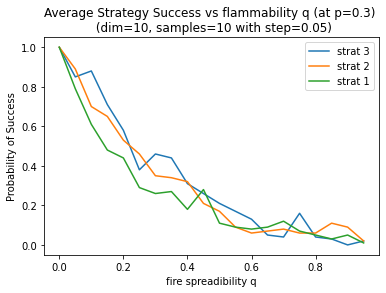

In [ ]:
# Settings
SAMPLE_COUNT = 20
STEP = 0.05
DIMENSION = 40

# Code to generate graph 
densities = np.arange(0.0, 1, STEP).tolist()
successes1 = dict()
successes2 = dict()
successes3 = dict()
density_count = len(densities)
with tqdm(total=density_count * SAMPLE_COUNT) as pbar:
    for i in range(len(densities)): 
        q = densities[i]
        if q not in successes2:
            successes1[q] = 0
            successes2[q] = 0
            successes3[q] = 0
        for j in range(SAMPLE_COUNT):
            successes1[q]+= test_strat1(dim=DIMENSION, q=q)
            successes2[q] += test_strat2(dim=DIMENSION, q=q)
            successes3[q] += test_strat3(dim=DIMENSION, q=q)
            pbar.update(1)

x_axis = densities
y_axis = [successes3[x] / (SAMPLE_COUNT*10) for x in densities]
y_2 = [successes2[x]/(SAMPLE_COUNT*10) for x in densities]
y_1 = [successes1[x]/(SAMPLE_COUNT*10) for x in densities]

plt.xlabel("fire spreadibility q")
plt.ylabel("Probability of Success")
plt.title("Average Strategy Success vs flammability q (at p=0.3) \n (dim=" + str(DIMENSION) + ", samples=" + str(SAMPLE_COUNT) + " with step=" + str(STEP) + ")")
plt.plot(x_axis, y_axis, label="strat 3")
plt.plot(x_axis, y_2, label="strat 2")
plt.plot(x_axis, y_1, label = "strat 1")
plt.legend()


The three strategies perform around the same at `q >= 0.7`. This is because our Strategy 3 uses the fire map (the worst case future of the fire using `q = 1.0`). At high `q` values such as `0.7` and higher, the worst case fire map that we use in our Strategy 3 A\* heuristic is not much worse than the actual fire growth because the actual `q` is very close to `1.0`. Because of this, we are unable to find a viable path to the goal without visiting a node that may be on fire. As a result, our Strategy 3 does about the same as the other two strategies at these high `q` values. However, our Strategy 3 performs better than or equal to the other two strategies at `0.0 <= q <= 0.7`. This is because we assume the worst case fire spread. This means we are assuming a much worse fire spread than the actual fire spread and as a result, the agent chooses a much safer route than Strategies 1 and 2 at these `q` values.

## Problem 7

### If you had unlimited computational resources at your disposal, how could you improve on Strategy 3?

Due to having limited computational resources, our current Strategy 3 only looks at the most optimal paths to the goal cell. We then pass those optimal paths to our risk assessment algorithm and pick the best path. However, if we had unlimited computation resources, our Strategy 3 would instead look at all possible paths to the goal cell. We could then pass every single path to our risk assessment algorithm which would greatly increase the chance that a viable path to the goal cell is found without catching on fire. For example, if a fire is near a spot that an optimal path may go through, our current Strategy 3 may not be able to escape the fire because it leverages optimal paths. However, with unlimited resources, we could look at all possible paths, therefore avoiding the fire by discovering a less risky but non-optimal path.

## Problem 8

### If you could only take ten seconds between moves (rather than doing as much computation as you like), how would that change your strategy? Describe such a potential Strategy 4.

Currently, every time we take a step, we recalculate all the optimal paths using A\* and recalculate the worst case fire map using the current fire. This takes a lot time and may take more than 10 seconds between steps. However, if we could only take ten seconds between moves rather than doing as much computation as we like, we would just calculate the next 5 steps and use that to decide which path to take, instead of calculating the entire optimal path. Due to the fact that calculating the entire fire map is extremely quick, we would not need to cut down on how often we recalculate the fire map because we would still be able to do this in less than 10 seconds between moves. As a result, our Strategy 4 would calculate just the next 5 steps using A* rather than calculating the entire optimal path to the goal in between steps. This would greatly cut down how much time we take between moves.